In [75]:
import matplotlib.pyplot as plt
import sys  
sys.path.insert(0, 'C:\\Users\\rmnso\\PycharmProjects\\bakalarkaFY')
sys.path.insert(0, 'C:\\Users\\rmnso\\PycharmProjects\\bakalarkaFY\\MicroCathode')
import os
os.chdir("C:\\Users\\rmnso\\PycharmProjects\\bakalarkaFY\\MicroCathode")
from solver import solve_numerical, solve_generic, solve_numerical_EN
from input_parser import parse_input_file, parse_table

In [76]:
from solver import solve_numerical
from input_parser import parse_input_file, parse_table
from solver import solve_generic
import numpy as np

filename = "micro_cathode_explicit.input"
all_species, parameters, reactions, tables = parse_input_file(filename)

# -------------------------- PREPARE UPDATE METHOD ------------------------------------

# 1eV = 11600 K
E = parse_table("mean energy", tables)
Te = lambda prmtrs: E(prmtrs['EN']) * 11_600 * 2/3
mobility = parse_table("mobility", tables)  # in 1/m

q_elem = 1.60217662e-19
k_B = 1.38064852e-23
Td_to_Vm2 = 1e-21
Vm2_to_Td = 1 / Td_to_Vm2
gas_density = parameters['gas_pressure'] / (k_B * parameters['gas_temperature'])
gap_area = np.pi * parameters['radius'] ** 2
voltage = 1000.0
resistance = 1.0e5

def update(prmtrs, time):
    neutral_particles = prmtrs['Ar'] + prmtrs['Ar*']
    J = q_elem * gap_area * prmtrs['e'] * mobility(prmtrs['EN']) * prmtrs['EN'] * Td_to_Vm2
    prmtrs['EN'] = Vm2_to_Td * voltage / neutral_particles / \
                   (prmtrs['gap_length'] + resistance * J / (prmtrs['EN'] * Td_to_Vm2 * neutral_particles))
    prmtrs['EN'] = 0.5 * (prmtrs['EN'] + abs(prmtrs['EN']))

parameters['EN'] = voltage / parameters['gap_length'] / gas_density * Vm2_to_Td

# -------------------------- PREPARE REACTION METHODS ------------------------------------

# original values (with not SI units)
gas_pressure = 100  # torr
Tgas = 300  # K
radius = 0.4  # cm
gap_length = 0.4  # cm

def diff_rate(prmtrs):
    return 1240.946565968663 * E(prmtrs['EN'])

# convert from cm^3/s to m^3/s
reactant2conv = 1e-6
# convert from cm^6/s to m^6/s
reactant3conv = 1e-12

def reaction_Ar2withe(prmtrs):
    # Ar2^+ + e => Ar* + Ar          !   8.5d-7 * (Te/300.0d0)**(-0.67d0)
    basic = 8.5e-7 * (Te(prmtrs)/300.0)**(-0.67)
    return basic * reactant2conv

def reaction_ArpAre(prmtrs):
    # Ar^+ + Ar + e => Ar + Ar       !   8.75d-27 * (Te/11600.0d0)**(-4.5d0)
    basic = 8.75e-27 * (Te(prmtrs)/11600.0)**(-4.5)
    return basic * reactant3conv

# -------------------------- SET REACTION RATES ------------------------------------

# Ar2^+ + e => Ar* + Ar          !   8.5d-7 * (Te/300.0d0)**(-0.67d0)
reactions[4].rate_fun = reaction_Ar2withe

# Ar^+ + Ar + e => Ar + Ar       !   8.75d-27 * (Te/11600.0d0)**(-4.5d0)
reactions[7].rate_fun = reaction_ArpAre

# diff_rate: diffusion losses
reactions[10].rate_fun = diff_rate
reactions[11].rate_fun = diff_rate
reactions[12].rate_fun = diff_rate

C:\Users\rmnso\PycharmProjects\bakalarkaFY\input_parser.py:138: UserWarning: The rate specification '8.5d-7 * (Te/300.0d0)**(-0.67d0)' cannot be parsed, because we only support constant rates and rates given by a table. You must write the rate function in the code yourself and assign it to the corresponding reaction.
  species.remove('+')
C:\Users\rmnso\PycharmProjects\bakalarkaFY\input_parser.py:138: UserWarning: The rate specification '8.75d-27 * (Te/11600.0d0)**(-4.5d0)' cannot be parsed, because we only support constant rates and rates given by a table. You must write the rate function in the code yourself and assign it to the corresponding reaction.
  species.remove('+')
C:\Users\rmnso\PycharmProjects\bakalarkaFY\input_parser.py:138: UserWarning: The rate specification 'diff_rate' cannot be parsed, because we only support constant rates and rates given by a table. You must write the rate function in the code yourself and assign it to the corresponding reaction.
  species.remove('+

In [12]:
# STOCHASTIC SOLUTION

def exp_bulk_compute(run, time, parameters, bulk):
    return bulk * 1.1

def print_out(run, time, parameters):
    print(f"run: {run}, time: {time}, EN: {parameters['EN']}, e: {parameters['e']}, Ar: {parameters['Ar']}, Ar+: {parameters['Ar^+']}")


def extract_params(line, prmtrs):
    spl = line.split(', ')
    for item in spl:
        item = item.strip()
        name, val = item.split(': ')
        prmtrs[name] = float(val)
    prmtrs['time_ini'] = prmtrs['time']
    del prmtrs['time']
file = open('bufferWithEN.txt', 'r')
last = file.readlines()[-1]
file.close()
extract_params(last, parameters)    

solve_generic(list(all_species) + ['EN'], parameters, reactions, update=update, bulk=1e13, bulk_compute=None, print_out=print_out, outfile='buffer.txt')

run: 0, time: 0.00014982690636075095, EN: 4.512660014405927, e: 2.4369627257484826e+17, Ar: 3.2187732211828216e+24, Ar+: 495799593774219.1
bulk: 10000000000000.0
run: 100000, time: 0.0001514844281455464, EN: 4.5309700591079425, e: 2.4290627257484826e+17, Ar: 3.218773211362966e+24, Ar+: 615799593774219.1
bulk: 10000000000000.0
run: 200000, time: 0.0001531306062855293, EN: 4.525158659501321, e: 2.4315627257484826e+17, Ar: 3.218773198963158e+24, Ar+: 485799593774219.1
bulk: 10000000000000.0
run: 300000, time: 0.0001547812766949814, EN: 4.520752596056759, e: 2.4334627257484826e+17, Ar: 3.2187731897132805e+24, Ar+: 475799593774219.1
bulk: 10000000000000.0
run: 400000, time: 0.00015644771309590333, EN: 4.516586844619697, e: 2.4352627257484826e+17, Ar: 3.21877318220336e+24, Ar+: 475799593774219.1
bulk: 10000000000000.0
run: 500000, time: 0.00015809264137115554, EN: 4.52515866110588, e: 2.4315627257484826e+17, Ar: 3.218773172983483e+24, Ar+: 545799593774219.1
bulk: 10000000000000.0
run: 600000

run: 5000000, time: 0.00023302277710664866, EN: 4.517280593733568, e: 2.4349627257484826e+17, Ar: 3.2187729470342737e+24, Ar+: 585799593774219.1
bulk: 10000000000000.0
run: 5100000, time: 0.0002346776509454857, EN: 4.5175118861957335, e: 2.4348627257484826e+17, Ar: 3.218772943634239e+24, Ar+: 385799593774219.1
bulk: 10000000000000.0
run: 5200000, time: 0.00023633291188542626, EN: 4.522606693601323, e: 2.4326627257484826e+17, Ar: 3.2187729341043723e+24, Ar+: 465799593774219.1
bulk: 10000000000000.0
run: 5300000, time: 0.0002379827196154818, EN: 4.524694460245037, e: 2.4317627257484826e+17, Ar: 3.2187729284844e+24, Ar+: 455799593774219.1
bulk: 10000000000000.0
run: 5400000, time: 0.00023962095059539348, EN: 4.529341294519802, e: 2.4297627257484826e+17, Ar: 3.2187729207444954e+24, Ar+: 435799593774219.1
bulk: 10000000000000.0
run: 5500000, time: 0.00024125658511356176, EN: 4.52423033605405, e: 2.4319627257484826e+17, Ar: 3.21877291120462e+24, Ar+: 525799593774219.1
bulk: 10000000000000.0


run: 10000000, time: 0.0003165988286947529, EN: 4.497483316967053, e: 2.4435627257484826e+17, Ar: 3.218772741643961e+24, Ar+: 455799593774219.1
bulk: 10000000000000.0
run: 10100000, time: 0.0003182766179060467, EN: 4.496337985337182, e: 2.4440627257484826e+17, Ar: 3.218772739933909e+24, Ar+: 525799593774219.1
bulk: 10000000000000.0
run: 10200000, time: 0.00031997773691898784, EN: 4.4819589626784895, e: 2.4503627257484826e+17, Ar: 3.218772737773839e+24, Ar+: 535799593774219.1
bulk: 10000000000000.0
run: 10300000, time: 0.00032169194361039184, EN: 4.482187209044046, e: 2.4502627257484826e+17, Ar: 3.2187727401936743e+24, Ar+: 445799593774219.1
bulk: 10000000000000.0
run: 10400000, time: 0.0003234034662151103, EN: 4.482414696853562, e: 2.4501627257484826e+17, Ar: 3.2187727408335584e+24, Ar+: 515799593774219.1
bulk: 10000000000000.0
run: 10500000, time: 0.00032511502521134956, EN: 4.489478996087898, e: 2.4470627257484826e+17, Ar: 3.2187727346435995e+24, Ar+: 425799593774219.1
bulk: 10000000

run: 14900000, time: 0.0003982919714027885, EN: 4.507819322827853, e: 2.4390627257484826e+17, Ar: 3.21877244152611e+24, Ar+: 495799593774219.1
bulk: 10000000000000.0
run: 15000000, time: 0.00039994719895987467, EN: 4.505288087295463, e: 2.4401627257484826e+17, Ar: 3.218772451595756e+24, Ar+: 515799593774219.1
bulk: 10000000000000.0
run: 15100000, time: 0.00040160646739649915, EN: 4.508510234687987, e: 2.4387627257484826e+17, Ar: 3.2187724537255866e+24, Ar+: 615799593774219.1
bulk: 10000000000000.0
run: 15200000, time: 0.0004032815408981109, EN: 4.4926771132654935, e: 2.4456627257484826e+17, Ar: 3.2187724598153203e+24, Ar+: 465799593774219.1
bulk: 10000000000000.0
run: 15300000, time: 0.00040496974531460016, EN: 4.4821872352690315, e: 2.4502627257484826e+17, Ar: 3.2187724658350687e+24, Ar+: 605799593774219.1
bulk: 10000000000000.0
run: 15400000, time: 0.00040666622518150953, EN: 4.48309728621522, e: 2.4498627257484826e+17, Ar: 3.2187724738247606e+24, Ar+: 495799593774219.1
bulk: 1000000

run: 19800000, time: 0.00048004711184798134, EN: 4.542640778424031, e: 2.4240627257484826e+17, Ar: 3.218772218636382e+24, Ar+: 455799593774219.1
bulk: 10000000000000.0
run: 19900000, time: 0.00048166692786109867, EN: 4.5492043377784865, e: 2.4212627257484826e+17, Ar: 3.2187721984767743e+24, Ar+: 615799593774219.1
bulk: 10000000000000.0
run: 20000000, time: 0.00048328437196271123, EN: 4.540769180519578, e: 2.4248627257484826e+17, Ar: 3.2187721863669675e+24, Ar+: 475799593774219.1
bulk: 10000000000000.0
run: 20100000, time: 0.00048490744189802, EN: 4.541704772086712, e: 2.4244627257484826e+17, Ar: 3.218772175377131e+24, Ar+: 565799593774219.1
bulk: 10000000000000.0
run: 20200000, time: 0.0004865352489487288, EN: 4.522606774175078, e: 2.4326627257484826e+17, Ar: 3.2187721741570525e+24, Ar+: 585799593774219.1
bulk: 10000000000000.0
run: 20300000, time: 0.0004881806397575317, EN: 4.516818167354226, e: 2.4351627257484826e+17, Ar: 3.218772176856882e+24, Ar+: 485799593774219.1
bulk: 1000000000

run: 24700000, time: 0.0005610833399843047, EN: 4.5184374110416075, e: 2.4344627257484826e+17, Ar: 3.2187719691974265e+24, Ar+: 495799593774219.1
bulk: 10000000000000.0
run: 24800000, time: 0.0005627441838336602, EN: 4.4965670800484, e: 2.4439627257484826e+17, Ar: 3.218771971567268e+24, Ar+: 615799593774219.1
bulk: 10000000000000.0
run: 24900000, time: 0.0005644191642835789, EN: 4.494506821711022, e: 2.4448627257484826e+17, Ar: 3.218771979246972e+24, Ar+: 435799593774219.1
bulk: 10000000000000.0
run: 25000000, time: 0.0005660918972531592, EN: 4.504138577837271, e: 2.4406627257484826e+17, Ar: 3.218771984076746e+24, Ar+: 475799593774219.1
bulk: 10000000000000.0
run: 25100000, time: 0.0005677767121305621, EN: 4.500923119115759, e: 2.4420627257484826e+17, Ar: 3.2187719790967673e+24, Ar+: 485799593774219.1
bulk: 10000000000000.0
run: 25200000, time: 0.000569453301654229, EN: 4.502070937359397, e: 2.4415627257484826e+17, Ar: 3.2187719703968767e+24, Ar+: 575799593774219.1
bulk: 10000000000000

run: 29600000, time: 0.0006431670852838742, EN: 4.503678951653906, e: 2.4408627257484826e+17, Ar: 3.218771761247296e+24, Ar+: 425799593774219.1
bulk: 10000000000000.0
run: 29700000, time: 0.0006448422771126895, EN: 4.494278053072918, e: 2.4449627257484826e+17, Ar: 3.2187717631771466e+24, Ar+: 575799593774219.1
bulk: 10000000000000.0
run: 29800000, time: 0.0006465311076072249, EN: 4.498858639580286, e: 2.4429627257484826e+17, Ar: 3.2187717603471014e+24, Ar+: 555799593774219.1
bulk: 10000000000000.0
run: 29900000, time: 0.0006482071797954968, EN: 4.500923144495416, e: 2.4420627257484826e+17, Ar: 3.218771758877019e+24, Ar+: 445799593774219.1
bulk: 10000000000000.0
run: 30000000, time: 0.0006498883936159601, EN: 4.496796149073504, e: 2.4438627257484826e+17, Ar: 3.21877175266707e+24, Ar+: 485799593774219.1
bulk: 10000000000000.0
run: 30100000, time: 0.0006515700961086693, EN: 4.500693656641673, e: 2.4421627257484826e+17, Ar: 3.2187717461871317e+24, Ar+: 615799593774219.1
bulk: 1000000000000

run: 34500000, time: 0.0007247009694700792, EN: 4.505058228121942, e: 2.4402627257484826e+17, Ar: 3.218771506258454e+24, Ar+: 475799593774219.1
bulk: 10000000000000.0
run: 34600000, time: 0.0007263791197889576, EN: 4.511751046590066, e: 2.4373627257484826e+17, Ar: 3.218771506368354e+24, Ar+: 495799593774219.1
bulk: 10000000000000.0
run: 34700000, time: 0.0007280454687854812, EN: 4.520752779878419, e: 2.4334627257484826e+17, Ar: 3.218771507038241e+24, Ar+: 545799593774219.1
bulk: 10000000000000.0
run: 34800000, time: 0.000729702728662875, EN: 4.507589190984848, e: 2.4391627257484826e+17, Ar: 3.218771506988126e+24, Ar+: 515799593774219.1
bulk: 10000000000000.0
run: 34900000, time: 0.000731366151495571, EN: 4.513814395377608, e: 2.4364627257484826e+17, Ar: 3.21877150074817e+24, Ar+: 445799593774219.1
bulk: 10000000000000.0
run: 35000000, time: 0.0007330403960904373, EN: 4.512660200620137, e: 2.4369627257484826e+17, Ar: 3.2187714961281753e+24, Ar+: 495799593774219.1
bulk: 10000000000000.0


run: 39500000, time: 0.0008089621274953203, EN: 4.512198710345362, e: 2.4371627257484826e+17, Ar: 3.2187712889984544e+24, Ar+: 475799593774219.1
bulk: 10000000000000.0
run: 39600000, time: 0.0008106329957462627, EN: 4.505748217434827, e: 2.4399627257484826e+17, Ar: 3.2187712815185203e+24, Ar+: 455799593774219.1
bulk: 10000000000000.0
run: 39700000, time: 0.0008123036405740726, EN: 4.524230519052377, e: 2.4319627257484826e+17, Ar: 3.218771272858628e+24, Ar+: 445799593774219.1
bulk: 10000000000000.0
run: 39800000, time: 0.000813969218516473, EN: 4.525855401795253, e: 2.4312627257484826e+17, Ar: 3.2187712611388017e+24, Ar+: 565799593774219.1
bulk: 10000000000000.0
run: 39900000, time: 0.0008156367453943979, EN: 4.522143209651447, e: 2.4328627257484826e+17, Ar: 3.2187712513189253e+24, Ar+: 675799593774219.1
bulk: 10000000000000.0
run: 40000000, time: 0.000817305857495796, EN: 4.514738231166242, e: 2.4360627257484826e+17, Ar: 3.2187712435389964e+24, Ar+: 475799593774219.1
bulk: 100000000000

run: 44400000, time: 0.0008906025107369306, EN: 4.500464072163081, e: 2.4422627257484826e+17, Ar: 3.2187710198998533e+24, Ar+: 435799593774219.1
bulk: 10000000000000.0
run: 44500000, time: 0.0008922791996597598, EN: 4.500234829673528, e: 2.4423627257484826e+17, Ar: 3.218771020269749e+24, Ar+: 485799593774219.1
bulk: 10000000000000.0
run: 44600000, time: 0.000893962988120805, EN: 4.480595664263627, e: 2.4509627257484826e+17, Ar: 3.2187710186896845e+24, Ar+: 675799593774219.1
bulk: 10000000000000.0
run: 44700000, time: 0.0008956632204968112, EN: 4.482642388517259, e: 2.4500627257484826e+17, Ar: 3.218771029449304e+24, Ar+: 435799593774219.1
bulk: 10000000000000.0
run: 44800000, time: 0.0008973725410665315, EN: 4.485830134076918, e: 2.4486627257484826e+17, Ar: 3.2187710328591247e+24, Ar+: 445799593774219.1
bulk: 10000000000000.0
run: 44900000, time: 0.0008990786158487925, EN: 4.486742593041333, e: 2.4482627257484826e+17, Ar: 3.218771035168978e+24, Ar+: 505799593774219.1
bulk: 1000000000000

run: 49300000, time: 0.0009727497619593268, EN: 4.516124748216611, e: 2.4354627257484826e+17, Ar: 3.2187707793206275e+24, Ar+: 425799593774219.1
bulk: 10000000000000.0
run: 49400000, time: 0.0009744043224763863, EN: 4.517974782149812, e: 2.4346627257484826e+17, Ar: 3.2187707741506556e+24, Ar+: 515799593774219.1
bulk: 10000000000000.0
run: 49500000, time: 0.0009760748410107887, EN: 4.51081487096985, e: 2.4377627257484826e+17, Ar: 3.2187707663507255e+24, Ar+: 345799593774219.1
bulk: 10000000000000.0
run: 49600000, time: 0.0009777429762121675, EN: 4.511506710914138, e: 2.4374627257484826e+17, Ar: 3.218770763680695e+24, Ar+: 575799593774219.1
bulk: 10000000000000.0
run: 49700000, time: 0.0009794090436497558, EN: 4.4974835265588355, e: 2.4435627257484826e+17, Ar: 3.21877076254062e+24, Ar+: 535799593774219.1
bulk: 10000000000000.0
run: 49800000, time: 0.0009810825649883973, EN: 4.49290591589842, e: 2.4455627257484826e+17, Ar: 3.2187707693903485e+24, Ar+: 435799593774219.1
bulk: 1000000000000

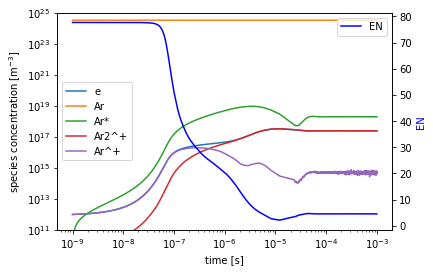

In [81]:
from plot import read_outfile, plot_with_EN

timesS, valuesS = read_outfile('bufferWithEN.txt')
plot_with_EN(timesS, valuesS, ['e', 'Ar', 'Ar*', 'Ar2^+', 'Ar^+'], xlog=True, ylim=(1e11, 1e25))
#plt.savefig('graphs/MicroCathodeImprovedMC.png', dpi=512)

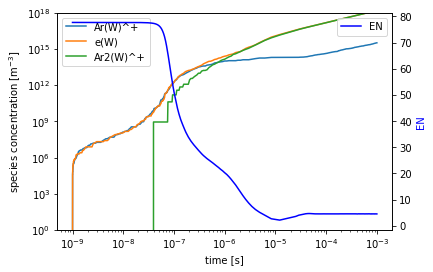

In [83]:
from plot import read_outfile, plot_with_EN
timesS, valuesS = read_outfile('bufferWithEN.txt')
plot_with_EN(timesS, valuesS, ['Ar(W)^+', 'e(W)', 'Ar2(W)^+'], xlog=True, ylim=(1e0, 1e18))
# plt.savefig('graphs/MicroCathodeImprovedMCLosses.png', dpi=512)

In [14]:
def solve_numerical_EN(all_species, parameters, reactions, update, precision=1e4, verbose=False):
    all_species = list(all_species)  # species need to be in an (any) order

    initial_concentrations = [parameters[specie] for specie in all_species]

    time_ini = parameters['time_ini']
    time_end = parameters['time_end']

    times = [time_ini]
    values = {species: [parameters[species]] for species in all_species}
    values['EN'] = [parameters['EN']]

    timestamps = np.logspace(np.log10(time_ini), np.log10(time_end), num=int(precision))

    # this function will be integrated (takes concentrations and time and returns concentration diffs)
    # it doesn't use the parameter t, as it assumes constant E/N set externally
    def fun(t, concentrations):
        differentials = []
        for specie in all_species:
            diff = 0
            for reaction in reactions:
                prod_change = reaction.products[specie] if specie in reaction.products else 0
                reac_change = reaction.reactants[specie] if specie in reaction.reactants else 0
                abs_change = prod_change - reac_change
                rate = reaction.rate_fun(parameters)
                product = abs_change * rate
                for reactant in reaction.reactants:
                    reactant_index = all_species.index(reactant)
                    product *= concentrations[reactant_index] ** reaction.reactants[reactant]
                diff += product
            differentials.append(diff)
        for i in range(len(all_species)):
            parameters[all_species[i]] = concentrations[i] 
        return differentials

    # loop through timestamps
    for i in range(int(precision) - 1):
        update(parameters, time=timestamps[i])  # set the current E/N as constant for the timestamp
        sol = solve_ivp(fun, (timestamps[i], timestamps[i + 1]), initial_concentrations, method='Radau')

        # store results
        times += list(sol.t)
        for j in range(len(all_species)):
            values[all_species[j]] += list(sol.y[j])

        # prepare initial_concentrations for the next computation
        initial_concentrations = [values[species][-1] for species in all_species]

        if verbose and i % (int(precision) // 100) == 0:  # print out progress for each percentage
            print(f"{int(i / int(precision)  * 100)} %, run {i}/{precision}, time: {timestamps[i]}")
        values['EN'] += [parameters['EN'] for _ in sol.t]  # store E/N ratio used in this timestamp

    return times, values

In [20]:
# DETERMINISTIC SOLUTION
from scipy.integrate import solve_ivp
times, values = solve_numerical_EN(all_species, parameters, reactions, update=update, precision=1e4, verbose=True)

0 %, run 0/10000.0, time: 1e-09
1 %, run 100/10000.0, time: 1.1481694855213497e-09
2 %, run 200/10000.0, time: 1.3182931674823609e-09
3 %, run 300/10000.0, time: 1.5136239878745327e-09
4 %, run 400/10000.0, time: 1.737896875430676e-09
5 %, run 500/10000.0, time: 1.9954001613524004e-09
6 %, run 600/10000.0, time: 2.2910575766692035e-09
7 %, run 700/10000.0, time: 2.6305223991040696e-09
8 %, run 800/10000.0, time: 3.0202855496317065e-09
9 %, run 900/10000.0, time: 3.4677997056482033e-09
10 %, run 1000/10000.0, time: 3.981621803925185e-09
11 %, run 1100/10000.0, time: 4.571576658153368e-09
12 %, run 1200/10000.0, time: 5.248944819613364e-09
13 %, run 1300/10000.0, time: 6.02667827306543e-09
14 %, run 1400/10000.0, time: 6.919648092188231e-09
15 %, run 1500/10000.0, time: 7.94492878999655e-09
16 %, run 1600/10000.0, time: 9.122124801314098e-09
17 %, run 1700/10000.0, time: 1.0473745339986352e-08
18 %, run 1800/10000.0, time: 1.2025634798493764e-08
19 %, run 1900/10000.0, time: 1.3807466919

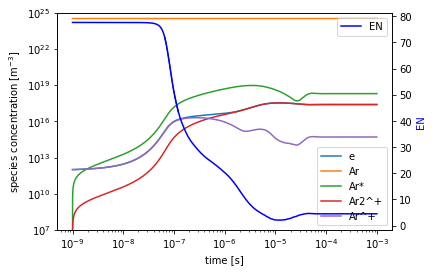

In [25]:
from plot import plot_with_EN
plot_with_EN(times, values, ['e', 'Ar', 'Ar*', 'Ar2^+', 'Ar^+'], xlog=True, ylim=(1e7, 1e25))
plt.savefig('graphs/MicroCathodeImprovedDeterministic.png', dpi=512)

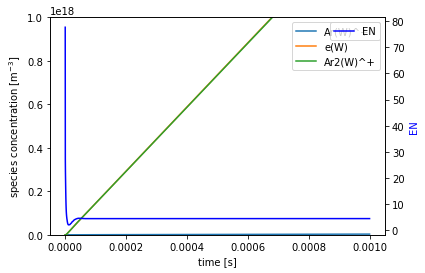

In [30]:
plot_with_EN(times, values, ['Ar(W)^+', 'e(W)', 'Ar2(W)^+'], xlog=True, ylim=(1e0, 1e18))
plt.savefig('graphs/MicroCathodeImprovedDeterministicLosses.png', dpi=512)